In [3]:
from test_dqn_mlp_total import *

#### 对比随机动作和启发式规则

In [2]:
"""
all_makespans = []
for instance in instances:
    print(instance)
    env = HeuristicJsspEnv(instance)
    agent = load_agent(instance=instance)
    makespans = []
    makespans.append(get_makespan_of_agent_policy(env=env,agent=agent))
    makespans.append(get_makespan_of_random_policy(env=env,num_simulations=10))
    for rule in range(8):
        makespans.append(get_makespan_of_heuristic_rule(env=env,rule=rule))
    all_makespans.append(makespans)

policies = ['agent', 'random', 'fifo', 'lifo', 'lpt', 'spt', 'ltpt', 'stpt','mor','lor']
df = pd.DataFrame(data = all_makespans,
				index = instances,
				columns = policies)
print(df)
df.to_csv("test_dqn_staic.csv")
"""

ft06
la01
la06
la11
la21
la31


KeyboardInterrupt: 

In [6]:
# 新的policy file的agent test结果（修正了reward后）
l = [59, 675, 938, 1222, 1221, 1817, 1424, 1134, 1668, 2077, 3403, 1045]      
df = pd.read_csv("test_dqn_staic.csv")
df['agent'] = l
df

,Unnamed: 0,agent,random,fifo,lifo,lpt,spt,ltpt,stpt,mor,lor
0,ft06,59,68.4,68,70,77,88,68,83,59,68
1,la01,675,801.1,830,764,822,751,835,933,763,941
2,la06,938,1054.0,1078,1031,1125,1200,1098,1012,926,1095
3,la11,1222,1361.6,1577,1580,1467,1473,1416,1446,1222,1586
4,la21,1221,1325.8,1417,1479,1451,1324,1278,1541,1251,1547
5,la31,1817,2031.0,2148,2256,2245,1951,2083,2270,1836,2129
6,la36,1424,1690.5,1676,1831,1737,1799,1750,1894,1492,1932
7,orb01,1134,1375.4,1456,1495,1410,1478,1308,1458,1307,1410
8,swv01,1668,1980.4,1889,2123,2145,1737,1961,1751,1971,1838
9,swv06,2077,2369.8,2243,2331,2542,2140,2327,2360,2287,2383


<AxesSubplot:>

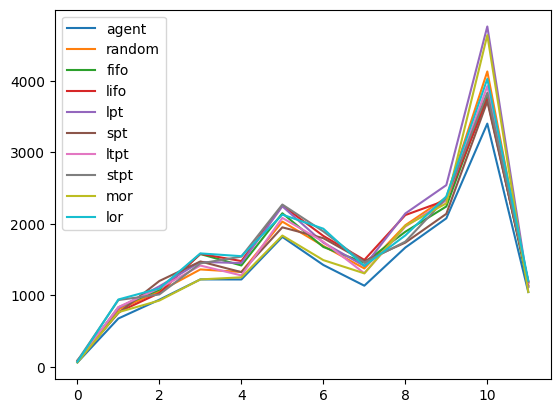

In [9]:
df.plot()

<AxesSubplot:>

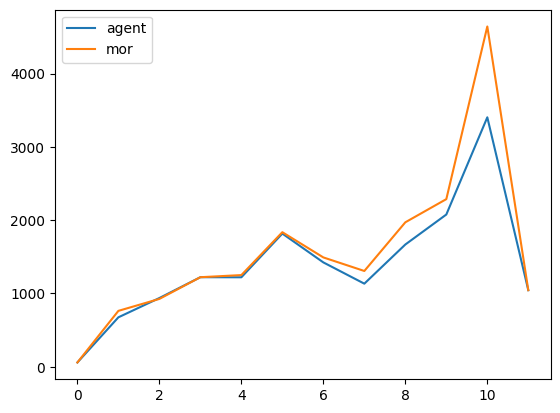

In [8]:
# mor是最好的启发式规则
df2 = pd.DataFrame()
df2['agent'], df2['mor'] = df['agent'], df['mor']
df2.plot()

In [13]:
# On large instances
# Agent train on swv11, test on swv11-swv20
large_instances  = [f"swv{x}" for x in range(11,21)]
agent = load_agent(instance="swv11")

all_makespans = []
for instance in large_instances:
    print(instance)
    env = HeuristicJsspEnv(instance)
    makespans = []
    makespans.append(get_makespan_of_agent_policy(env=env,agent=agent))
    # makespans.append(get_makespan_of_random_policy(env=env,num_simulations=10))
    # for rule in range(8):
    #     makespans.append(get_makespan_of_heuristic_rule(env=env,rule=rule))
    makespans.append(get_makespan_of_heuristic_rule(env=env,rule=6))        # only mor
    all_makespans.append(makespans)

# policies = ['agent', 'random', 'fifo', 'lifo', 'lpt', 'spt', 'ltpt', 'stpt','mor','lor']
policies = ['agent', 'mor']
df_large = pd.DataFrame(data = all_makespans,
				index = large_instances,
				columns = policies)
df_large.to_csv("test_dqn_staic_large_vs_mor.csv")
df_large

swv11
swv12
swv13
swv14
swv15
swv16
swv17
swv18
swv19
swv20


,agent,mor
swv11,3403,4642
swv12,4283,4821
swv13,4151,4755
swv14,3803,4740
swv15,3890,4905
swv16,2928,2924
swv17,2949,2848
swv18,3036,2852
swv19,3033,3060
swv20,2860,2851


<AxesSubplot:>

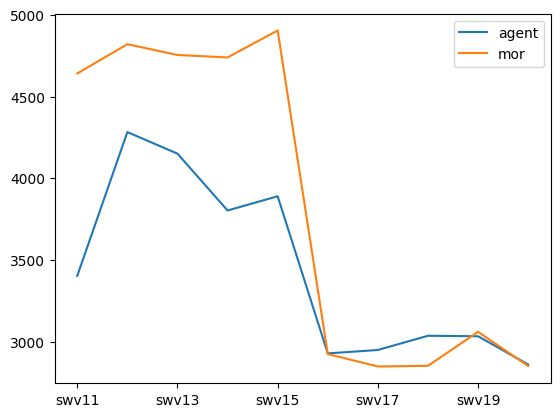

In [14]:
df_large.plot()

<AxesSubplot:>

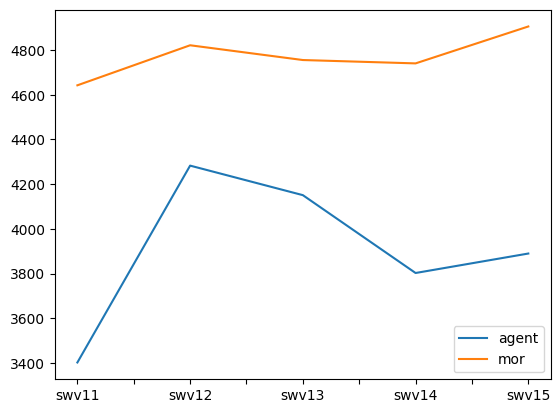

In [17]:
df_large[:5].plot()

#### 随机环境

agent vs ortools-static

In [21]:
random_rate = 0.5
cv = 0.2
n = 10
directory = f"figs_no_future_infomation/p{random_rate}cv{cv}num_episodes{num_episodes}_dqn_5_4"

if not os.path.exists(directory):
    os.makedirs(directory)

ret = {}

ortools_mean, ortools_std, policy_mean, policy_std = [], [], [], []
ortools_on_original, policy_on_original = [], []
optimal_mean, optimal_std = [], []
ortools_300s_optimal_rate = []
current_instances = []
all_policy_vals = []

for instance in instances:
    sols_directory = f"sols/{instance}/p{random_rate}cv{cv}"
    policy_file = f"policies/dqn_mlp/{instance}_num_episodes={num_episodes}_memory_size={memory_size}_target_update={target_update}_noisy={noisy}_cycle=8.pth"
    env = HeuristicJsspEnv(instance)
    agent = DQNAgent(env, memory_size, batch_size, target_update, noisy=noisy)
    agent.load_dqn(policy_file)
    makespan = agent.test()
    model = agent._get_dqn()
    ret[instance] = makespan

    scheduler = ORtools_scheduler(instance)
    #scheduler.optimize()
    #obj_val = scheduler.obj_val
    scheduler.read_solution()           # 读取静态解
    obj_val = scheduler.compute_makespan()

    policy_vals, ortools_vals, optimal_vals, if_optimals = [], [], [], []

    for i in range(n):
        scheduler.load_time_mat(os.path.join(sols_directory, f"{i}.npy"))
        times = scheduler.times
        
        policy_val = scheduler.policy_makespan('dqn', model, shifted_time=times)
        ortools_val = scheduler.compute_makespan(shifted_time=times)        # 静态调度面对工时波动

        policy_vals.append(policy_val)
        ortools_vals.append(ortools_val)

    info_df = pd.read_csv(os.path.join(sols_directory, "info.csv")) ##############################
    optimal_vals, if_optimals = info_df['obj_val'].values.tolist(), info_df['optimal'].values.tolist()

    plt.plot(policy_vals, color='g', label='policy')
    plt.plot(ortools_vals, color='r', label='ortools_static')
    plt.plot(optimal_vals, color='blue', label='ortools_300s')
    all_policy_vals.append(policy_vals)
    policy_vals, ortools_vals, optimal_vals = np.array(policy_vals), np.array(ortools_vals), np.array(optimal_vals)

    plt.hlines(np.mean(ortools_vals), -2, n+2, linestyles='dotted', colors='r')
    plt.hlines(np.mean(policy_vals), -2, n+2, linestyles='dotted', colors='g')
    plt.hlines(np.mean(optimal_vals), -2, n+2, linestyles='dotted', colors='blue')
    scatter_x = np.where(if_optimals)
    scatter_y = np.array(optimal_vals)[scatter_x]
    plt.scatter(scatter_x, scatter_y, color='blue')



    ortools_mean.append(np.mean(ortools_vals))
    ortools_std.append(np.std(ortools_vals))
    policy_mean.append(np.mean(policy_vals))
    policy_std.append(np.std(policy_vals))
    optimal_mean.append(np.mean(optimal_vals))
    optimal_std.append(np.std(optimal_vals))
    ortools_on_original.append(obj_val)
    policy_on_original.append(makespan)
    ortools_300s_optimal_rate.append(np.mean(if_optimals))
    current_instances.append(instance)

    plt.xlabel('trial')
    plt.ylabel('makespan')
    plt.title(f"random_rate={random_rate},cv={cv},instance={instance}")
    plt.legend()
    plt.savefig(f"{directory}/policy_vs_ortools_{instance}.png")
    plt.clf()

    
df = pd.DataFrame()
# 将每个列添加到 DataFrame 中
df['instance'] = current_instances
df['ortools_mean'] = ortools_mean
df['policy_mean'] = policy_mean
df['optimal_mean'] = optimal_mean
df['ortools_std'] = ortools_std
df['policy_std'] = policy_std
df['optimal_std'] = optimal_std
df['ortools_on_original'] = ortools_on_original
df['policy_on_original'] = policy_on_original
df['ortools_300s_optimal_rate'] = ortools_300s_optimal_rate

if os.path.exists(f"{directory}/data.csv"):
    df2 = pd.read_csv(f"{directory}/data.csv")
    df2 = df2.append(df, ignore_index=True)
    df2.to_csv(f"{directory}/data.csv", index=False)
else:
    df.to_csv(f"{directory}/data.csv", index=False)

<Figure size 640x480 with 0 Axes>

In [25]:
df_policy_vals = pd.DataFrame(all_policy_vals,index=instances)

In [26]:
df_policy_vals

,0,1,2,3,4,5,6,7,8,9
ft06,62,79,107,64,83,51,72,72,77,78
la01,831,887,1012,1100,1074,971,940,1051,851,1009
la06,1023,1020,1334,1057,1269,941,1094,1183,1180,1020
la11,1193,1599,1523,1163,1363,1655,1070,1337,1364,1567
la21,1417,1455,1200,1436,1595,1517,1545,1607,1367,1630
la31,2234,2167,2005,2167,2299,2307,2254,2208,2485,1857
la36,1669,1882,1668,1700,1680,1709,1628,1632,1955,1701
orb01,1585,1407,1435,1495,1421,1373,1303,1357,1615,1429
swv01,1815,2218,1884,1711,1780,2189,1968,1629,2431,2164
swv06,2528,2524,2338,2317,2326,2437,2514,2163,2275,2288


In [28]:
np.mean(all_policy_vals, axis=1)

array([  74.5,  972.6, 1112.1, 1383.4, 1476.9, 2198.3, 1722.4, 1442. ,
       1978.9, 2371. , 3977.5, 1243.1])

In [30]:
all_heuristic_vals = []
for instance in instances:
    sols_directory = f"sols/{instance}/p{random_rate}cv{cv}"
    scheduler = ORtools_scheduler(instance)
    scheduler.read_solution()           # 读取静态解
    l = []
    for i in range(n):
        scheduler.load_time_mat(os.path.join(sols_directory, f"{i}.npy"))
        times = scheduler.times
        env = HeuristicJsspEnv(instance, shifted_time=times)
        x = get_makespan_of_heuristic_rule(env=env, rule=6)
        l.append(x)
    all_heuristic_vals.append(l)

In [32]:
df_heuristic_6_vals = pd.DataFrame(all_heuristic_vals, index=instances)
df_heuristic_6_vals

,0,1,2,3,4,5,6,7,8,9
ft06,65,79,77,55,71,53,67,67,70,71
la01,932,1149,788,1180,915,692,805,955,877,1015
la06,1023,1020,1304,966,1283,784,1164,1133,1180,1028
la11,1267,1599,1523,1163,1357,1414,1106,1329,1364,1522
la21,1293,1578,1339,1310,1545,1464,1735,1670,1357,1433
la31,2234,2199,2027,2195,2324,2363,2366,2208,2392,1779
la36,1669,1808,1695,1743,1721,1609,1628,1632,1708,1689
orb01,1317,1345,1674,1631,1296,1405,1301,1587,1554,1465
swv01,2160,2361,2223,2097,1944,2467,2171,1928,2572,2183
swv06,2723,2703,2595,2770,2520,2932,2561,2340,2583,2592


<AxesSubplot:>

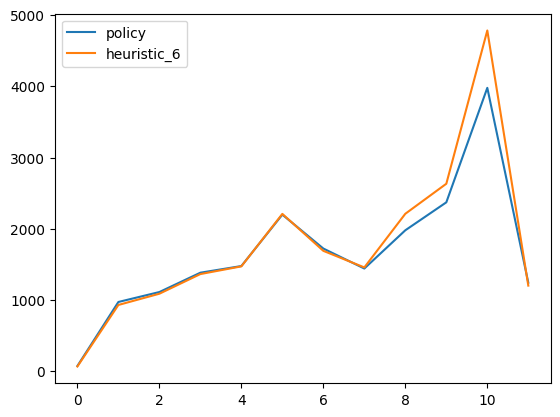

In [37]:
df_compare = pd.DataFrame()
df_compare['policy'] = np.mean(all_policy_vals, axis=1)
df_compare['heuristic_6'] = np.mean(all_heuristic_vals, axis=1)
df_compare.plot()

#### 上图说明，波动情形下，大算例policy还是能够优于heuristic rule